# Loading NWB files using Neo

This notebook demonstrates how to load electrophysiology data using Neo for eFEL eFeatures extraction.

In [1]:
import efel

import numpy

%matplotlib notebook
%matplotlib inline
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = 10, 10

We will use the voltage trace recordings obtained from a mouse thalamic cell classified as a bursting accommodating (bAC) etype. The data is stored in an NWB (Neurodata Without Borders) file, and we will use the [Python Neo](https://github.com/NeuralEnsemble/python-neo) library to load it.

In [ ]:
test_data = "../../tests/testdata/JY180308_A_1.nwb"
stim_start = 250
stim_end = 600
blocks = efel.io.load_neo_file(test_data, stim_start, stim_end)
traces = blocks[0][0]

Let's get a trace that includes a burst

In [3]:
trace = traces[5]

In [4]:
time = trace['T']
voltage = trace['V']

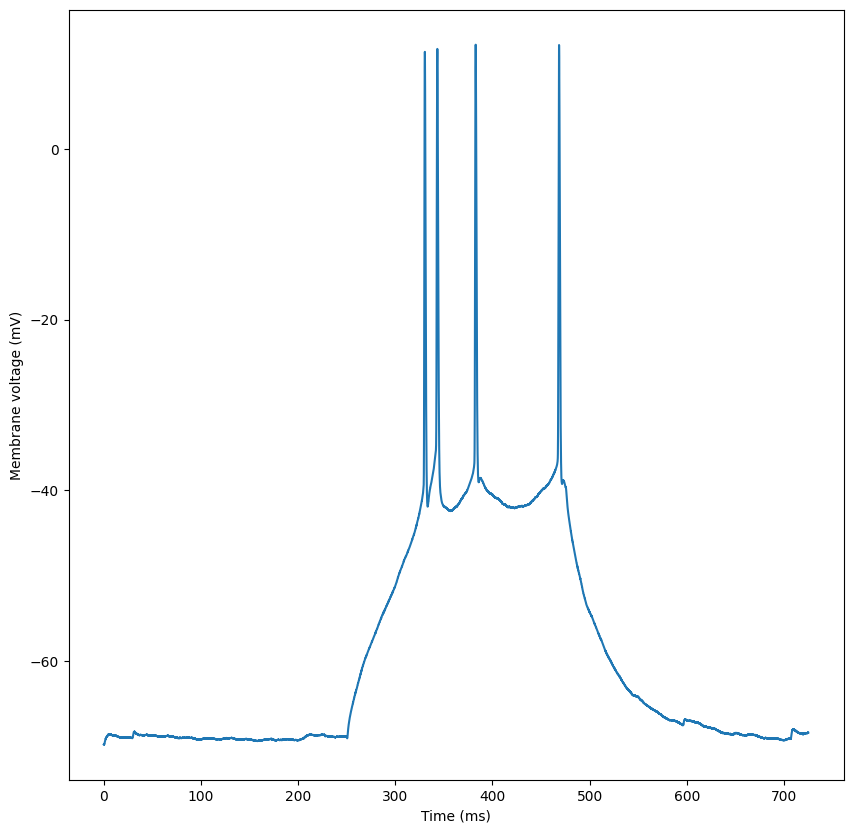

In [5]:
plt.rcParams['figure.figsize'] = 10, 10

fig1, ax1 = plt.subplots(1)
ax1.plot(time, voltage)
ax1.set_xlabel('Time (ms)')
ax1.set_ylabel('Membrane voltage (mV)');

We can now use the eFEL to extract eFeature values from the trace shown above.

We will use the ``get_feature_values()`` function, which accepts a list of trace and the requested eFeature names as input.

Let's extract some burst-related features

In [6]:
efel.set_setting("ignore_first_ISI", False) # Don't ignore the first spike
efel.set_setting("strict_burst_factor", 4.0) # The burst detection can be fine-tuned by changing the setting strict_burst_factor. Default value is 2.0.
feature_values = efel.get_feature_values([trace], ['spikes_per_burst', 'strict_burst_number', 'strict_burst_mean_freq', 'peak_time', 'AP_height', 'peak_indices', 'burst_begin_indices', 'burst_end_indices'])[0]
feature_values = {feature_name: list(values) for feature_name, values in feature_values.items()}
feature_values

{'spikes_per_burst': [4],
 'strict_burst_number': [1],
 'strict_burst_mean_freq': [28.964518464873937],
 'peak_time': [330.4000000000066,
  343.20000000000954,
  382.7000000000185,
  468.500000000038],
 'AP_height': [11.400000572174852,
  11.712499618465365,
  12.237500190711486,
  12.19999980918174],
 'peak_indices': [3304, 3432, 3827, 4685],
 'burst_begin_indices': [0],
 'burst_end_indices': [3]}

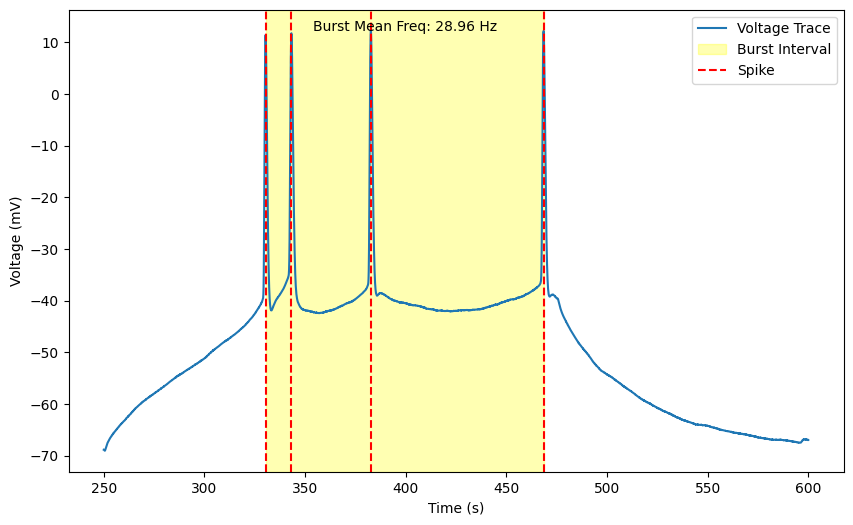

In [7]:
burst_begin_indices = feature_values['burst_begin_indices'][0]
burst_end_indices = feature_values['burst_end_indices'][0]
peak_times = feature_values['peak_time']
ap_heights = feature_values['AP_height']
burst_mean_freq = feature_values['strict_burst_mean_freq']

time_spike_indices = numpy.where((time > stim_start) & (time < stim_end))
time_spike = time[time_spike_indices]
voltage_spike = voltage[time_spike_indices]

plt.figure(figsize=(10, 6))
plt.plot(time_spike, voltage_spike, label='Voltage Trace')

burst_start = peak_times[burst_begin_indices]
burst_end = peak_times[burst_end_indices]
mean_frequency = burst_mean_freq[0]

plt.axvspan(burst_start, burst_end, color='yellow', alpha=0.3, label='Burst Interval')

for spike_time in peak_times[burst_begin_indices:burst_end_indices+1]:
    plt.axvline(x=spike_time, color='red', linestyle='--', label='Spike' if 'Spike' not in plt.gca().get_legend_handles_labels()[1] else "")

plt.text((burst_start + burst_end) / 2, max(voltage_spike), f'Burst Mean Freq: {mean_frequency:.2f} Hz', horizontalalignment='center', color='black')

plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Voltage (mV)')
plt.show()